# Check GPU

In [1]:
#Check for GPU
import tensorflow as tf
# if tf.test.gpu_device_name():
#     print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
# else:
#     print('Please install GPU version of TF')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
#check keras and tf versions
import keras
print(keras.__version__)
import tensorflow as tf
print(tf.__version__)

2.4.3
2.2.0


In [3]:
from __future__ import division
# For displaying audio and images in notebook
#import IPython.display as ipd

from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
import time
import os
import sys
from os import listdir
from os.path import isdir, join, dirname, join, realpath
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tfcochleagram
import h5py
import math
# Helper functions for loading audio
from utils import *
import librosa,glob,os

# Preprocessing

In [4]:
#create dicts from csv
##------------------------------ Dataset -------------------------------------##
import csv
import threading


#csv.field_size_limit(10**7)

def read_dict(path):
    'Reads Python dictionary stored in a csv file'
    dictionary = {}
    for key, val in csv.reader(open(path)):
        dictionary[key] = val
    return dictionary

# Load partitions
partition = read_dict('PATH/partition.csv')

def read_patterns(csv_file):
    '''
    Reads in target patterns of the form:
        label,v1,v2,...,vN
    '''
    pattern_dict = {}
    with open(csv_file,'r') as f:
        for line in f:
            atoms = line.strip().split(',')
            word = atoms[0]
            pattern = np.array([float(x) for x in atoms[1:]])
            pattern_dict[word] = pattern
    return pattern_dict

# Load dictionary of labels
labels = read_patterns('PATH/DualCombined_1819.csv')
#print(labels)


exec("partition['train'] = " + partition['train'])
exec("partition['validation'] = " + partition['validation'])
exec("partition['test'] = " + partition['test'])

# # Final computations
# partition['train'] = partition['train'] 
# partition['validation'] = partition['validation']
# partition['test'] = partition['test']

partition['train'] = partition['train'] + partition['validation']
partition['validation'] = partition['test']

In [5]:
max_len = 226
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    my_list = [] #global variable for getting the IDs
    my_labels = [] #global variable for getting the labels
    def __init__(self, list_IDs, labels, batch_size=100, dim=(max_len,211), #n_channels=1,
                 n_classes=1819, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        #self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.my_list = []
        self.my_labels = []
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # FA and NS added this part to get the names of the words
        if index == 0:
            indexes2 = self.indexes[index*800:(index+1)*800]
            list_IDs_temp2 = [self.list_IDs[k] for k in indexes2]
            self.my_list = list_IDs_temp2 # This is for getting shuffled list_IDs for get_my_list
        
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))#, self.n_channels))
        #y = np.empty((self.batch_size), dtype=int)
        y = np.empty((self.batch_size, max_len, self.n_classes), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('Cochs/' + ID + '.npy') #data1 for the toy

            # Store class
            y[i] = self.labels[ID]

        return X, y

# Build and Train LSTM

In [6]:
from keras import backend as K
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Embedding, LSTM, Masking, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import json
import pandas as pd
from keras.optimizers import Adam, SGD, RMSprop
from keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [7]:
# Parameters
params = {'dim': (max_len,211),
          'batch_size': 100,
          'n_classes': 1819,
          #'n_channels': 1,
          'shuffle': True}

# Datasets
partition = partition
labels = labels

# Generators
training_generator = DataGenerator(partition['train'], labels, **params) #9 token per word
validation_generator = DataGenerator(partition['validation'], labels, **params) #1 token per word

In [8]:
data_dim = 211

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(Masking(mask_value=-9999, input_shape=(max_len, data_dim))) #The mask value has to equal whatever the junk value was that you used to pad the inputs. 0. is a bad idea because it might actually occur in the cgram. In EARSHOT we use -9999.
model.add(LSTM(512, return_sequences=True))
model.add(Dense(1819, activation='sigmoid')) 
#bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
opt = keras.optimizers.Adam(learning_rate=0.0001)#, clipnorm=0.01)
#sgd=SGD(lr=1e-3, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(loss='mse',
              optimizer=opt)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 226, 211)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 226, 512)          1482752   
_________________________________________________________________
dense (Dense)                (None, 226, 1819)         933147    
Total params: 2,415,899
Trainable params: 2,415,899
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# Early Stopping and checkpoint
# Set callback functions to early stop training and save the best model so far
# earlystop = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50),
#              ModelCheckpoint(filepath='VentralModel_EarlyStop.h5', monitor='val_loss', save_best_only=True)]

# checkpoint
checkpoints = ModelCheckpoint('checkpoints/' + '_{epoch:02d}' + '.hd5f',
                              monitor="loss",
                              verbose=0,
                              #save_best_only=True,
                              save_weights_only=False,
                              mode="min",
                              save_freq=7900)

from keras.callbacks import TerminateOnNaN
terminate = TerminateOnNaN()

In [ ]:
#Here we train the Network.
#history = model.fit(X_train, Y_train, batch_size=100, epochs=1000, validation_data=(X_valid, Y_valid))
history = model.fit_generator(generator=training_generator,
                              epochs=10000,
                              validation_data=validation_generator,
                              callbacks=[checkpoints], #earlystop,
                              #use_multiprocessing=True,
                              workers=6)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10000
79/79 [==============================] - 34s 431ms/step - loss: 0.0972 - val_loss: 0.0658
Epoch 2/10000
79/79 [==============================] - 33s 418ms/step - loss: 0.0648 - val_loss: 0.0643
Epoch 3/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0641 - val_loss: 0.0637
Epoch 4/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0638 - val_loss: 0.0628
Epoch 5/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0636 - val_loss: 0.0633
Epoch 6/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0634 - val_loss: 0.0626
Epoch 7/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0633 - val_loss: 0.0629
Epoch 8/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0632 - val_loss: 0.0629
Epoch 9/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0632 - val_l

79/79 [==============================] - 33s 418ms/step - loss: 0.0620 - val_loss: 0.0617
Epoch 149/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0620 - val_loss: 0.0617
Epoch 150/10000
79/79 [==============================] - 33s 418ms/step - loss: 0.0619 - val_loss: 0.0616
Epoch 151/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0619 - val_loss: 0.0619
Epoch 152/10000
79/79 [==============================] - 33s 420ms/step - loss: 0.0619 - val_loss: 0.0618
Epoch 153/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0618 - val_loss: 0.0619
Epoch 154/10000
79/79 [==============================] - 33s 413ms/step - loss: 0.0618 - val_loss: 0.0612
Epoch 155/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0618 - val_loss: 0.0617
Epoch 156/10000
79/79 [==============================] - 33s 413ms/step - loss: 0.0618 - val_loss: 0.0619
Epoch 157/10000
79/79 [==============================] - 33s 4

79/79 [==============================] - 37s 473ms/step - loss: 0.0592 - val_loss: 0.0596
Epoch 301/10000
79/79 [==============================] - 33s 418ms/step - loss: 0.0592 - val_loss: 0.0599
Epoch 302/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0590 - val_loss: 0.0591
Epoch 303/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0590 - val_loss: 0.0594
Epoch 304/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0589 - val_loss: 0.0593
Epoch 305/10000
79/79 [==============================] - 33s 413ms/step - loss: 0.0590 - val_loss: 0.0594
Epoch 306/10000
79/79 [==============================] - 33s 418ms/step - loss: 0.0589 - val_loss: 0.0594
Epoch 307/10000
79/79 [==============================] - 33s 418ms/step - loss: 0.0590 - val_loss: 0.0594
Epoch 308/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0589 - val_loss: 0.0588
Epoch 309/10000
79/79 [==============================] - 33s 4

79/79 [==============================] - 33s 414ms/step - loss: 0.0557 - val_loss: 0.0571
Epoch 454/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0556 - val_loss: 0.0569
Epoch 455/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0557 - val_loss: 0.0566
Epoch 456/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0558 - val_loss: 0.0572
Epoch 457/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0556 - val_loss: 0.0568
Epoch 458/10000
79/79 [==============================] - 33s 418ms/step - loss: 0.0554 - val_loss: 0.0571
Epoch 459/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0555 - val_loss: 0.0566
Epoch 460/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0553 - val_loss: 0.0576
Epoch 461/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0553 - val_loss: 0.0571
Epoch 462/10000
79/79 [==============================] - 33s 4

79/79 [==============================] - 33s 414ms/step - loss: 0.0518 - val_loss: 0.0546
Epoch 606/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0514 - val_loss: 0.0549
Epoch 607/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0516 - val_loss: 0.0552
Epoch 608/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0510 - val_loss: 0.0542
Epoch 609/10000
79/79 [==============================] - 33s 419ms/step - loss: 0.0511 - val_loss: 0.0548
Epoch 610/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0516 - val_loss: 0.0548
Epoch 611/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0510 - val_loss: 0.0548
Epoch 612/10000
79/79 [==============================] - 33s 413ms/step - loss: 0.0511 - val_loss: 0.0545
Epoch 613/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0514 - val_loss: 0.0550
Epoch 614/10000
79/79 [==============================] - 33s 4

79/79 [==============================] - 33s 418ms/step - loss: 0.0481 - val_loss: 0.0538
Epoch 759/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0477 - val_loss: 0.0535
Epoch 760/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0478 - val_loss: 0.0538
Epoch 761/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0498 - val_loss: 0.0547
Epoch 762/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0490 - val_loss: 0.0532
Epoch 763/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0480 - val_loss: 0.0538
Epoch 764/10000
79/79 [==============================] - 33s 419ms/step - loss: 0.0477 - val_loss: 0.0534
Epoch 765/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0475 - val_loss: 0.0539
Epoch 766/10000
79/79 [==============================] - 33s 413ms/step - loss: 0.0474 - val_loss: 0.0536
Epoch 767/10000
79/79 [==============================] - 33s 4

79/79 [==============================] - 33s 415ms/step - loss: 0.0448 - val_loss: 0.0529
Epoch 911/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0447 - val_loss: 0.0525
Epoch 912/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0444 - val_loss: 0.0525
Epoch 913/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0444 - val_loss: 0.0532
Epoch 914/10000
79/79 [==============================] - 33s 413ms/step - loss: 0.0445 - val_loss: 0.0524
Epoch 915/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0441 - val_loss: 0.0522
Epoch 916/10000
79/79 [==============================] - 33s 418ms/step - loss: 0.0448 - val_loss: 0.0552
Epoch 917/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0453 - val_loss: 0.0527
Epoch 918/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0442 - val_loss: 0.0525
Epoch 919/10000
79/79 [==============================] - 33s 4

79/79 [==============================] - 33s 417ms/step - loss: 0.0415 - val_loss: 0.0519
Epoch 1063/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0413 - val_loss: 0.0521
Epoch 1064/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0411 - val_loss: 0.0516
Epoch 1065/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0412 - val_loss: 0.0525
Epoch 1066/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0413 - val_loss: 0.0516
Epoch 1067/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0422 - val_loss: 0.0523
Epoch 1068/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0429 - val_loss: 0.0531
Epoch 1069/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0425 - val_loss: 0.0519
Epoch 1070/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0427 - val_loss: 0.0527
Epoch 1071/10000
79/79 [==============================

79/79 [==============================] - 33s 414ms/step - loss: 0.0389 - val_loss: 0.0520
Epoch 1213/10000
79/79 [==============================] - 33s 418ms/step - loss: 0.0389 - val_loss: 0.0524
Epoch 1214/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0393 - val_loss: 0.0523
Epoch 1215/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0396 - val_loss: 0.0521
Epoch 1216/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0389 - val_loss: 0.0524
Epoch 1217/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0390 - val_loss: 0.0511
Epoch 1218/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0393 - val_loss: 0.0516
Epoch 1219/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0408 - val_loss: 0.0518
Epoch 1220/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0396 - val_loss: 0.0514
Epoch 1221/10000
79/79 [==============================

79/79 [==============================] - 33s 416ms/step - loss: 0.0365 - val_loss: 0.0520
Epoch 1364/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0365 - val_loss: 0.0516
Epoch 1365/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0375 - val_loss: 0.0529
Epoch 1366/10000
79/79 [==============================] - 33s 418ms/step - loss: 0.0411 - val_loss: 0.0515
Epoch 1367/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0379 - val_loss: 0.0521
Epoch 1368/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0371 - val_loss: 0.0504
Epoch 1369/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0373 - val_loss: 0.0510
Epoch 1370/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0386 - val_loss: 0.0534
Epoch 1371/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0383 - val_loss: 0.0511
Epoch 1372/10000
79/79 [==============================

79/79 [==============================] - 33s 416ms/step - loss: 0.0357 - val_loss: 0.0512
Epoch 1514/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0352 - val_loss: 0.0504
Epoch 1515/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0350 - val_loss: 0.0507
Epoch 1516/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0348 - val_loss: 0.0512
Epoch 1517/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0346 - val_loss: 0.0516
Epoch 1518/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0345 - val_loss: 0.0518
Epoch 1519/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0345 - val_loss: 0.0514
Epoch 1520/10000
79/79 [==============================] - 33s 413ms/step - loss: 0.0362 - val_loss: 0.0532
Epoch 1521/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0369 - val_loss: 0.0518
Epoch 1522/10000
79/79 [==============================

79/79 [==============================] - 33s 412ms/step - loss: 0.0332 - val_loss: 0.0508
Epoch 1665/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0328 - val_loss: 0.0514
Epoch 1666/10000
79/79 [==============================] - 33s 413ms/step - loss: 0.0325 - val_loss: 0.0510
Epoch 1667/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0324 - val_loss: 0.0512
Epoch 1668/10000
79/79 [==============================] - 33s 412ms/step - loss: 0.0351 - val_loss: 0.0522
Epoch 1669/10000
79/79 [==============================] - 33s 418ms/step - loss: 0.0348 - val_loss: 0.0519
Epoch 1670/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0335 - val_loss: 0.0512
Epoch 1671/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0330 - val_loss: 0.0512
Epoch 1672/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0333 - val_loss: 0.0519
Epoch 1673/10000
79/79 [==============================

79/79 [==============================] - 33s 417ms/step - loss: 0.0326 - val_loss: 0.0533
Epoch 1815/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0390 - val_loss: 0.0523
Epoch 1816/10000
79/79 [==============================] - 33s 413ms/step - loss: 0.0387 - val_loss: 0.0507
Epoch 1817/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0375 - val_loss: 0.0512
Epoch 1818/10000
79/79 [==============================] - 33s 413ms/step - loss: 0.0342 - val_loss: 0.0503
Epoch 1819/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0327 - val_loss: 0.0507
Epoch 1820/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0321 - val_loss: 0.0499
Epoch 1821/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0314 - val_loss: 0.0514
Epoch 1822/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0313 - val_loss: 0.0512
Epoch 1823/10000
79/79 [==============================

79/79 [==============================] - 33s 417ms/step - loss: 0.0371 - val_loss: 0.0533
Epoch 1966/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0345 - val_loss: 0.0516
Epoch 1967/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0327 - val_loss: 0.0534
Epoch 1968/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0328 - val_loss: 0.0519
Epoch 1969/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0311 - val_loss: 0.0522
Epoch 1970/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0307 - val_loss: 0.0510
Epoch 1971/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0300 - val_loss: 0.0503
Epoch 1972/10000
79/79 [==============================] - 33s 411ms/step - loss: 0.0298 - val_loss: 0.0511
Epoch 1973/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0297 - val_loss: 0.0509
Epoch 1974/10000
79/79 [==============================

79/79 [==============================] - 33s 417ms/step - loss: 0.0303 - val_loss: 0.0518
Epoch 2116/10000
79/79 [==============================] - 33s 413ms/step - loss: 0.0294 - val_loss: 0.0514
Epoch 2117/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0286 - val_loss: 0.0506
Epoch 2118/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0285 - val_loss: 0.0514
Epoch 2119/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0284 - val_loss: 0.0508
Epoch 2120/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0283 - val_loss: 0.0518
Epoch 2121/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0283 - val_loss: 0.0515
Epoch 2122/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0281 - val_loss: 0.0515
Epoch 2123/10000
79/79 [==============================] - 33s 418ms/step - loss: 0.0281 - val_loss: 0.0512
Epoch 2124/10000
79/79 [==============================

79/79 [==============================] - 33s 413ms/step - loss: 0.0278 - val_loss: 0.0509
Epoch 2267/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0276 - val_loss: 0.0508
Epoch 2268/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0274 - val_loss: 0.0510
Epoch 2269/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0277 - val_loss: 0.0506
Epoch 2270/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0274 - val_loss: 0.0512
Epoch 2271/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0272 - val_loss: 0.0511
Epoch 2272/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0272 - val_loss: 0.0507
Epoch 2273/10000
79/79 [==============================] - 33s 412ms/step - loss: 0.0272 - val_loss: 0.0514
Epoch 2274/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0272 - val_loss: 0.0514
Epoch 2275/10000
79/79 [==============================

79/79 [==============================] - 33s 416ms/step - loss: 0.0269 - val_loss: 0.0504
Epoch 2417/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0267 - val_loss: 0.0506
Epoch 2418/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0265 - val_loss: 0.0507
Epoch 2419/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0264 - val_loss: 0.0506
Epoch 2420/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0263 - val_loss: 0.0505
Epoch 2421/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0263 - val_loss: 0.0507
Epoch 2422/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0262 - val_loss: 0.0512
Epoch 2423/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0262 - val_loss: 0.0512
Epoch 2424/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0262 - val_loss: 0.0511
Epoch 2425/10000
79/79 [==============================

79/79 [==============================] - 33s 415ms/step - loss: 0.0289 - val_loss: 0.0522
Epoch 2568/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0277 - val_loss: 0.0506
Epoch 2569/10000
79/79 [==============================] - 33s 413ms/step - loss: 0.0274 - val_loss: 0.0531
Epoch 2570/10000
79/79 [==============================] - 33s 413ms/step - loss: 0.0293 - val_loss: 0.0551
Epoch 2571/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0303 - val_loss: 0.0499
Epoch 2572/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0270 - val_loss: 0.0499
Epoch 2573/10000
79/79 [==============================] - 33s 412ms/step - loss: 0.0265 - val_loss: 0.0512
Epoch 2574/10000
79/79 [==============================] - 33s 413ms/step - loss: 0.0266 - val_loss: 0.0512
Epoch 2575/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0265 - val_loss: 0.0519
Epoch 2576/10000
79/79 [==============================

79/79 [==============================] - 33s 415ms/step - loss: 0.0256 - val_loss: 0.0508
Epoch 2718/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0261 - val_loss: 0.0513
Epoch 2719/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0287 - val_loss: 0.0537
Epoch 2720/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0278 - val_loss: 0.0512
Epoch 2721/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0290 - val_loss: 0.0521
Epoch 2722/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0281 - val_loss: 0.0518
Epoch 2723/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0280 - val_loss: 0.0527
Epoch 2724/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0262 - val_loss: 0.0523
Epoch 2725/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0256 - val_loss: 0.0518
Epoch 2726/10000
79/79 [==============================

79/79 [==============================] - 33s 414ms/step - loss: 0.0276 - val_loss: 0.0536
Epoch 2869/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0272 - val_loss: 0.0514
Epoch 2870/10000
79/79 [==============================] - 33s 412ms/step - loss: 0.0281 - val_loss: 0.0513
Epoch 2871/10000
79/79 [==============================] - 33s 411ms/step - loss: 0.0500 - val_loss: 0.0630
Epoch 2872/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0498 - val_loss: 0.0575
Epoch 2873/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0401 - val_loss: 0.0544
Epoch 2874/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0402 - val_loss: 0.0648
Epoch 2875/10000
79/79 [==============================] - 33s 422ms/step - loss: 0.0444 - val_loss: 0.0531
Epoch 2876/10000
79/79 [==============================] - 33s 418ms/step - loss: 0.0335 - val_loss: 0.0516
Epoch 2877/10000
79/79 [==============================

79/79 [==============================] - 33s 415ms/step - loss: 0.0265 - val_loss: 0.0521
Epoch 3019/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0264 - val_loss: 0.0512
Epoch 3020/10000
79/79 [==============================] - 32s 410ms/step - loss: 0.0250 - val_loss: 0.0508
Epoch 3021/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0245 - val_loss: 0.0509
Epoch 3022/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0242 - val_loss: 0.0512
Epoch 3023/10000
79/79 [==============================] - 33s 416ms/step - loss: 0.0238 - val_loss: 0.0517
Epoch 3024/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0235 - val_loss: 0.0520
Epoch 3025/10000
79/79 [==============================] - 33s 414ms/step - loss: 0.0234 - val_loss: 0.0512
Epoch 3026/10000
79/79 [==============================] - 33s 415ms/step - loss: 0.0261 - val_loss: 0.0558
Epoch 3027/10000
79/79 [==============================

79/79 [==============================] - 36s 461ms/step - loss: 0.0239 - val_loss: 0.0538
Epoch 3170/10000
79/79 [==============================] - 36s 458ms/step - loss: 0.0272 - val_loss: 0.0533
Epoch 3171/10000
79/79 [==============================] - 33s 418ms/step - loss: 0.0279 - val_loss: 0.0530
Epoch 3172/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0408 - val_loss: 0.0586
Epoch 3173/10000
79/79 [==============================] - 33s 420ms/step - loss: 0.0458 - val_loss: 0.0588
Epoch 3174/10000
79/79 [==============================] - 36s 457ms/step - loss: 0.0471 - val_loss: 0.0557
Epoch 3175/10000
79/79 [==============================] - 35s 441ms/step - loss: 0.0368 - val_loss: 0.0529
Epoch 3176/10000
79/79 [==============================] - 33s 422ms/step - loss: 0.0333 - val_loss: 0.0528
Epoch 3177/10000
79/79 [==============================] - 33s 420ms/step - loss: 0.0301 - val_loss: 0.0518
Epoch 3178/10000
79/79 [==============================

79/79 [==============================] - 33s 418ms/step - loss: 0.0224 - val_loss: 0.0519
Epoch 3320/10000
79/79 [==============================] - 33s 420ms/step - loss: 0.0223 - val_loss: 0.0518
Epoch 3321/10000
79/79 [==============================] - 33s 420ms/step - loss: 0.0303 - val_loss: 0.0560
Epoch 3322/10000
79/79 [==============================] - 33s 421ms/step - loss: 0.0370 - val_loss: 0.0533
Epoch 3323/10000
79/79 [==============================] - 33s 419ms/step - loss: 0.0294 - val_loss: 0.0523
Epoch 3324/10000
79/79 [==============================] - 33s 418ms/step - loss: 0.0258 - val_loss: 0.0522
Epoch 3325/10000
79/79 [==============================] - 33s 422ms/step - loss: 0.0243 - val_loss: 0.0515
Epoch 3326/10000
79/79 [==============================] - 33s 420ms/step - loss: 0.0238 - val_loss: 0.0509
Epoch 3327/10000
79/79 [==============================] - 33s 417ms/step - loss: 0.0233 - val_loss: 0.0509
Epoch 3328/10000
79/79 [==============================

79/79 [==============================] - 27s 344ms/step - loss: 0.0244 - val_loss: 0.0517
Epoch 3472/10000
79/79 [==============================] - 27s 341ms/step - loss: 0.0231 - val_loss: 0.0511
Epoch 3473/10000
79/79 [==============================] - 27s 342ms/step - loss: 0.0236 - val_loss: 0.0520
Epoch 3474/10000
79/79 [==============================] - 27s 342ms/step - loss: 0.0242 - val_loss: 0.0509
Epoch 3475/10000
79/79 [==============================] - 27s 340ms/step - loss: 0.0238 - val_loss: 0.0509
Epoch 3476/10000
79/79 [==============================] - 27s 340ms/step - loss: 0.0234 - val_loss: 0.0505
Epoch 3477/10000
79/79 [==============================] - 27s 344ms/step - loss: 0.0232 - val_loss: 0.0515
Epoch 3478/10000
79/79 [==============================] - 27s 344ms/step - loss: 0.0227 - val_loss: 0.0508
Epoch 3479/10000
79/79 [==============================] - 27s 342ms/step - loss: 0.0226 - val_loss: 0.0516
Epoch 3480/10000
79/79 [==============================

79/79 [==============================] - 27s 344ms/step - loss: 0.0260 - val_loss: 0.0520
Epoch 3622/10000
79/79 [==============================] - 27s 347ms/step - loss: 0.0250 - val_loss: 0.0513
Epoch 3623/10000
79/79 [==============================] - 27s 344ms/step - loss: 0.0241 - val_loss: 0.0523
Epoch 3624/10000
79/79 [==============================] - 27s 344ms/step - loss: 0.0238 - val_loss: 0.0522
Epoch 3625/10000
79/79 [==============================] - 27s 345ms/step - loss: 0.0235 - val_loss: 0.0538
Epoch 3626/10000
79/79 [==============================] - 27s 340ms/step - loss: 0.0232 - val_loss: 0.0521
Epoch 3627/10000
79/79 [==============================] - 27s 346ms/step - loss: 0.0228 - val_loss: 0.0524
Epoch 3628/10000
79/79 [==============================] - 27s 345ms/step - loss: 0.0239 - val_loss: 0.0550
Epoch 3629/10000
79/79 [==============================] - 27s 348ms/step - loss: 0.0245 - val_loss: 0.0521
Epoch 3630/10000
79/79 [==============================

79/79 [==============================] - 27s 345ms/step - loss: 0.0223 - val_loss: 0.0517
Epoch 3773/10000
79/79 [==============================] - 27s 342ms/step - loss: 0.0217 - val_loss: 0.0523
Epoch 3774/10000
79/79 [==============================] - 27s 346ms/step - loss: 0.0214 - val_loss: 0.0531
Epoch 3775/10000
79/79 [==============================] - 27s 345ms/step - loss: 0.0213 - val_loss: 0.0527
Epoch 3776/10000
79/79 [==============================] - 27s 345ms/step - loss: 0.0215 - val_loss: 0.0528
Epoch 3777/10000
79/79 [==============================] - 27s 343ms/step - loss: 0.0254 - val_loss: 0.0545
Epoch 3778/10000
79/79 [==============================] - 27s 344ms/step - loss: 0.0292 - val_loss: 0.0524
Epoch 3779/10000
79/79 [==============================] - 27s 344ms/step - loss: 0.0233 - val_loss: 0.0522
Epoch 3780/10000
79/79 [==============================] - 27s 345ms/step - loss: 0.0232 - val_loss: 0.0522
Epoch 3781/10000
79/79 [==============================

79/79 [==============================] - 28s 348ms/step - loss: 0.0214 - val_loss: 0.0522
Epoch 3923/10000
79/79 [==============================] - 27s 347ms/step - loss: 0.0213 - val_loss: 0.0524
Epoch 3924/10000
79/79 [==============================] - 28s 350ms/step - loss: 0.0209 - val_loss: 0.0525
Epoch 3925/10000
79/79 [==============================] - 27s 344ms/step - loss: 0.0215 - val_loss: 0.0586
Epoch 3926/10000
79/79 [==============================] - 28s 348ms/step - loss: 0.0578 - val_loss: 0.0659
Epoch 3927/10000
79/79 [==============================] - 28s 350ms/step - loss: 0.0487 - val_loss: 0.0559
Epoch 3928/10000
79/79 [==============================] - 27s 346ms/step - loss: 0.0374 - val_loss: 0.0539
Epoch 3929/10000
79/79 [==============================] - 27s 345ms/step - loss: 0.0322 - val_loss: 0.0530
Epoch 3930/10000
79/79 [==============================] - 27s 344ms/step - loss: 0.0318 - val_loss: 0.0568
Epoch 3931/10000
79/79 [==============================

79/79 [==============================] - 27s 347ms/step - loss: 0.0270 - val_loss: 0.0519
Epoch 4074/10000
79/79 [==============================] - 28s 350ms/step - loss: 0.0251 - val_loss: 0.0506
Epoch 4075/10000
79/79 [==============================] - 28s 351ms/step - loss: 0.0241 - val_loss: 0.0513
Epoch 4076/10000
79/79 [==============================] - 28s 350ms/step - loss: 0.0234 - val_loss: 0.0521
Epoch 4077/10000
79/79 [==============================] - 28s 352ms/step - loss: 0.0228 - val_loss: 0.0514
Epoch 4078/10000
79/79 [==============================] - 27s 347ms/step - loss: 0.0223 - val_loss: 0.0523
Epoch 4079/10000
79/79 [==============================] - 28s 350ms/step - loss: 0.0221 - val_loss: 0.0510
Epoch 4080/10000
79/79 [==============================] - 28s 350ms/step - loss: 0.0227 - val_loss: 0.0510
Epoch 4081/10000
79/79 [==============================] - 27s 346ms/step - loss: 0.0218 - val_loss: 0.0519
Epoch 4082/10000
79/79 [==============================

79/79 [==============================] - 28s 350ms/step - loss: 0.0208 - val_loss: 0.0515
Epoch 4224/10000
79/79 [==============================] - 28s 351ms/step - loss: 0.0207 - val_loss: 0.0509
Epoch 4225/10000
79/79 [==============================] - 28s 353ms/step - loss: 0.0217 - val_loss: 0.0519
Epoch 4226/10000
79/79 [==============================] - 28s 351ms/step - loss: 0.0209 - val_loss: 0.0517
Epoch 4227/10000
79/79 [==============================] - 28s 351ms/step - loss: 0.0206 - val_loss: 0.0520
Epoch 4228/10000
79/79 [==============================] - 28s 350ms/step - loss: 0.0204 - val_loss: 0.0514
Epoch 4229/10000
79/79 [==============================] - 28s 349ms/step - loss: 0.0203 - val_loss: 0.0521
Epoch 4230/10000
79/79 [==============================] - 28s 351ms/step - loss: 0.0208 - val_loss: 0.0510
Epoch 4231/10000
79/79 [==============================] - 28s 352ms/step - loss: 0.0234 - val_loss: 0.0534
Epoch 4232/10000
79/79 [==============================

79/79 [==============================] - 28s 350ms/step - loss: 0.0250 - val_loss: 0.0507
Epoch 4375/10000
79/79 [==============================] - 28s 354ms/step - loss: 0.0286 - val_loss: 0.0516
Epoch 4376/10000
79/79 [==============================] - 28s 351ms/step - loss: 0.0267 - val_loss: 0.0529
Epoch 4377/10000
79/79 [==============================] - 28s 350ms/step - loss: 0.0272 - val_loss: 0.0515
Epoch 4378/10000
79/79 [==============================] - 28s 353ms/step - loss: 0.0240 - val_loss: 0.0520
Epoch 4379/10000
79/79 [==============================] - 28s 352ms/step - loss: 0.0225 - val_loss: 0.0507
Epoch 4380/10000
79/79 [==============================] - 28s 352ms/step - loss: 0.0219 - val_loss: 0.0514
Epoch 4381/10000
79/79 [==============================] - 28s 352ms/step - loss: 0.0213 - val_loss: 0.0504
Epoch 4382/10000
79/79 [==============================] - 28s 352ms/step - loss: 0.0214 - val_loss: 0.0506
Epoch 4383/10000
79/79 [==============================

79/79 [==============================] - 28s 352ms/step - loss: 0.0209 - val_loss: 0.0516
Epoch 4525/10000
79/79 [==============================] - 28s 352ms/step - loss: 0.0215 - val_loss: 0.0521
Epoch 4526/10000
79/79 [==============================] - 28s 351ms/step - loss: 0.0205 - val_loss: 0.0519
Epoch 4527/10000
79/79 [==============================] - 28s 349ms/step - loss: 0.0199 - val_loss: 0.0521
Epoch 4528/10000
79/79 [==============================] - 28s 349ms/step - loss: 0.0197 - val_loss: 0.0522
Epoch 4529/10000
79/79 [==============================] - 28s 350ms/step - loss: 0.0196 - val_loss: 0.0526
Epoch 4530/10000
79/79 [==============================] - 28s 353ms/step - loss: 0.0194 - val_loss: 0.0520
Epoch 4531/10000
79/79 [==============================] - 28s 351ms/step - loss: 0.0193 - val_loss: 0.0524
Epoch 4532/10000
79/79 [==============================] - 28s 353ms/step - loss: 0.0194 - val_loss: 0.0523
Epoch 4533/10000
79/79 [==============================

79/79 [==============================] - 28s 355ms/step - loss: 0.0196 - val_loss: 0.0524
Epoch 4676/10000
79/79 [==============================] - 28s 353ms/step - loss: 0.0210 - val_loss: 0.0529
Epoch 4677/10000
79/79 [==============================] - 27s 347ms/step - loss: 0.0235 - val_loss: 0.0521
Epoch 4678/10000
79/79 [==============================] - 28s 357ms/step - loss: 0.0208 - val_loss: 0.0529
Epoch 4679/10000
79/79 [==============================] - 28s 351ms/step - loss: 0.0202 - val_loss: 0.0531
Epoch 4680/10000
79/79 [==============================] - 28s 352ms/step - loss: 0.0205 - val_loss: 0.0537
Epoch 4681/10000
79/79 [==============================] - 28s 354ms/step - loss: 0.0216 - val_loss: 0.0535
Epoch 4682/10000
79/79 [==============================] - 28s 352ms/step - loss: 0.0214 - val_loss: 0.0521
Epoch 4683/10000
79/79 [==============================] - 28s 352ms/step - loss: 0.0205 - val_loss: 0.0525
Epoch 4684/10000
79/79 [==============================

79/79 [==============================] - 45s 573ms/step - loss: 0.0191 - val_loss: 0.0529
Epoch 4826/10000
79/79 [==============================] - 71s 901ms/step - loss: 0.0190 - val_loss: 0.0527
Epoch 4827/10000
79/79 [==============================] - 105s 1s/step - loss: 0.0189 - val_loss: 0.0529
Epoch 4828/10000
79/79 [==============================] - 104s 1s/step - loss: 0.0190 - val_loss: 0.0533
Epoch 4829/10000
79/79 [==============================] - 106s 1s/step - loss: 0.0190 - val_loss: 0.0532
Epoch 4830/10000
79/79 [==============================] - 107s 1s/step - loss: 0.0190 - val_loss: 0.0532
Epoch 4831/10000
79/79 [==============================] - 107s 1s/step - loss: 0.0190 - val_loss: 0.0529
Epoch 4832/10000
79/79 [==============================] - 102s 1s/step - loss: 0.0324 - val_loss: 0.0570
Epoch 4833/10000
79/79 [==============================] - 111s 1s/step - loss: 0.0286 - val_loss: 0.0547
Epoch 4834/10000
79/79 [==============================] - 115s 1s/st

Epoch 4901/10000
79/79 [==============================] - 29s 365ms/step - loss: 0.0210 - val_loss: 0.0512
Epoch 4902/10000
79/79 [==============================] - 29s 368ms/step - loss: 0.0201 - val_loss: 0.0524
Epoch 4903/10000
79/79 [==============================] - 29s 364ms/step - loss: 0.0196 - val_loss: 0.0516
Epoch 4904/10000
79/79 [==============================] - 29s 365ms/step - loss: 0.0193 - val_loss: 0.0521
Epoch 4905/10000
79/79 [==============================] - 29s 369ms/step - loss: 0.0194 - val_loss: 0.0530
Epoch 4906/10000
79/79 [==============================] - 29s 365ms/step - loss: 0.0211 - val_loss: 0.0512
Epoch 4907/10000
79/79 [==============================] - 29s 365ms/step - loss: 0.0201 - val_loss: 0.0531
Epoch 4908/10000
79/79 [==============================] - 29s 364ms/step - loss: 0.0199 - val_loss: 0.0528
Epoch 4909/10000
79/79 [==============================] - 29s 369ms/step - loss: 0.0195 - val_loss: 0.0524
Epoch 4910/10000
79/79 [=============

79/79 [==============================] - 29s 366ms/step - loss: 0.0267 - val_loss: 0.0555
Epoch 5053/10000
79/79 [==============================] - 29s 367ms/step - loss: 0.0270 - val_loss: 0.0531
Epoch 5054/10000
79/79 [==============================] - 29s 367ms/step - loss: 0.0224 - val_loss: 0.0522
Epoch 5055/10000
79/79 [==============================] - 29s 368ms/step - loss: 0.0439 - val_loss: 0.0539
Epoch 5056/10000
79/79 [==============================] - 29s 367ms/step - loss: 0.0256 - val_loss: 0.0523
Epoch 5057/10000
79/79 [==============================] - 29s 365ms/step - loss: 0.0224 - val_loss: 0.0529
Epoch 5058/10000
79/79 [==============================] - 29s 365ms/step - loss: 0.0224 - val_loss: 0.0519
Epoch 5059/10000
79/79 [==============================] - 29s 367ms/step - loss: 0.0217 - val_loss: 0.0523
Epoch 5060/10000
79/79 [==============================] - 29s 366ms/step - loss: 0.0207 - val_loss: 0.0520
Epoch 5061/10000
79/79 [==============================

79/79 [==============================] - 29s 367ms/step - loss: 0.0189 - val_loss: 0.0509
Epoch 5203/10000
79/79 [==============================] - 29s 365ms/step - loss: 0.0185 - val_loss: 0.0516
Epoch 5204/10000
79/79 [==============================] - 29s 365ms/step - loss: 0.0190 - val_loss: 0.0509
Epoch 5205/10000
79/79 [==============================] - 29s 369ms/step - loss: 0.0185 - val_loss: 0.0516
Epoch 5206/10000
79/79 [==============================] - 29s 366ms/step - loss: 0.0183 - val_loss: 0.0518
Epoch 5207/10000
79/79 [==============================] - 29s 365ms/step - loss: 0.0182 - val_loss: 0.0522
Epoch 5208/10000
79/79 [==============================] - 29s 370ms/step - loss: 0.0181 - val_loss: 0.0517
Epoch 5209/10000
79/79 [==============================] - 29s 369ms/step - loss: 0.0181 - val_loss: 0.0520
Epoch 5210/10000
79/79 [==============================] - 29s 368ms/step - loss: 0.0180 - val_loss: 0.0521
Epoch 5211/10000
79/79 [==============================

79/79 [==============================] - 29s 368ms/step - loss: 0.0210 - val_loss: 0.0536
Epoch 5354/10000
79/79 [==============================] - 29s 369ms/step - loss: 0.0207 - val_loss: 0.0534
Epoch 5355/10000
79/79 [==============================] - 29s 368ms/step - loss: 0.0204 - val_loss: 0.0523
Epoch 5356/10000
79/79 [==============================] - 29s 366ms/step - loss: 0.0202 - val_loss: 0.0530
Epoch 5357/10000
79/79 [==============================] - 29s 366ms/step - loss: 0.0199 - val_loss: 0.0533
Epoch 5358/10000
79/79 [==============================] - 29s 368ms/step - loss: 0.0200 - val_loss: 0.0527
Epoch 5359/10000
79/79 [==============================] - 29s 370ms/step - loss: 0.0198 - val_loss: 0.0522
Epoch 5360/10000
79/79 [==============================] - 29s 368ms/step - loss: 0.0196 - val_loss: 0.0526
Epoch 5361/10000
79/79 [==============================] - 29s 365ms/step - loss: 0.0195 - val_loss: 0.0531
Epoch 5362/10000
79/79 [==============================

79/79 [==============================] - 29s 369ms/step - loss: 0.0197 - val_loss: 0.0529
Epoch 5504/10000
79/79 [==============================] - 29s 369ms/step - loss: 0.0348 - val_loss: 0.0570
Epoch 5505/10000
79/79 [==============================] - 29s 367ms/step - loss: 0.0351 - val_loss: 0.0561
Epoch 5506/10000
79/79 [==============================] - 29s 368ms/step - loss: 0.0296 - val_loss: 0.0586
Epoch 5507/10000
79/79 [==============================] - 29s 372ms/step - loss: 0.0333 - val_loss: 0.0567
Epoch 5508/10000
79/79 [==============================] - 29s 367ms/step - loss: 0.0273 - val_loss: 0.0527
Epoch 5509/10000
79/79 [==============================] - 29s 369ms/step - loss: 0.0325 - val_loss: 0.0561
Epoch 5510/10000
79/79 [==============================] - 29s 370ms/step - loss: 0.0291 - val_loss: 0.0529
Epoch 5511/10000
79/79 [==============================] - 29s 370ms/step - loss: 0.0251 - val_loss: 0.0530
Epoch 5512/10000
79/79 [==============================

79/79 [==============================] - 35s 447ms/step - loss: 0.0185 - val_loss: 0.0524
Epoch 5655/10000
79/79 [==============================] - 36s 450ms/step - loss: 0.0183 - val_loss: 0.0516
Epoch 5656/10000
79/79 [==============================] - 36s 450ms/step - loss: 0.0183 - val_loss: 0.0527
Epoch 5657/10000
79/79 [==============================] - 36s 451ms/step - loss: 0.0181 - val_loss: 0.0525
Epoch 5658/10000
79/79 [==============================] - 36s 453ms/step - loss: 0.0182 - val_loss: 0.0529
Epoch 5659/10000
79/79 [==============================] - 36s 453ms/step - loss: 0.0180 - val_loss: 0.0523
Epoch 5660/10000
79/79 [==============================] - 35s 442ms/step - loss: 0.0178 - val_loss: 0.0526
Epoch 5661/10000
79/79 [==============================] - 36s 450ms/step - loss: 0.0178 - val_loss: 0.0533
Epoch 5662/10000
79/79 [==============================] - 36s 452ms/step - loss: 0.0178 - val_loss: 0.0523
Epoch 5663/10000
79/79 [==============================

79/79 [==============================] - 34s 435ms/step - loss: 0.0185 - val_loss: 0.0498
Epoch 5805/10000
79/79 [==============================] - 42s 531ms/step - loss: 0.0185 - val_loss: 0.0521
Epoch 5806/10000
79/79 [==============================] - 34s 428ms/step - loss: 0.0188 - val_loss: 0.0507
Epoch 5807/10000
79/79 [==============================] - 42s 532ms/step - loss: 0.0184 - val_loss: 0.0517
Epoch 5808/10000
79/79 [==============================] - 36s 450ms/step - loss: 0.0182 - val_loss: 0.0506
Epoch 5809/10000
79/79 [==============================] - 39s 500ms/step - loss: 0.0182 - val_loss: 0.0512
Epoch 5810/10000
79/79 [==============================] - 36s 460ms/step - loss: 0.0181 - val_loss: 0.0508
Epoch 5811/10000
79/79 [==============================] - 38s 484ms/step - loss: 0.0180 - val_loss: 0.0515
Epoch 5812/10000
79/79 [==============================] - 39s 488ms/step - loss: 0.0180 - val_loss: 0.0515
Epoch 5813/10000
79/79 [==============================

79/79 [==============================] - 34s 427ms/step - loss: 0.0197 - val_loss: 0.0510
Epoch 5956/10000
79/79 [==============================] - 41s 522ms/step - loss: 0.0351 - val_loss: 0.0554
Epoch 5957/10000
79/79 [==============================] - 33s 423ms/step - loss: 0.0287 - val_loss: 0.0528
Epoch 5958/10000
79/79 [==============================] - 42s 527ms/step - loss: 0.0234 - val_loss: 0.0502
Epoch 5959/10000
79/79 [==============================] - 35s 444ms/step - loss: 0.0217 - val_loss: 0.0505
Epoch 5960/10000
79/79 [==============================] - 39s 500ms/step - loss: 0.0219 - val_loss: 0.0543
Epoch 5961/10000
79/79 [==============================] - 37s 468ms/step - loss: 0.0244 - val_loss: 0.0513
Epoch 5962/10000
79/79 [==============================] - 38s 475ms/step - loss: 0.0220 - val_loss: 0.0514
Epoch 5963/10000
79/79 [==============================] - 39s 488ms/step - loss: 0.0233 - val_loss: 0.0527
Epoch 5964/10000
79/79 [==============================

79/79 [==============================] - 46s 581ms/step - loss: 0.0202 - val_loss: 0.0546
Epoch 6106/10000
79/79 [==============================] - 37s 471ms/step - loss: 0.0187 - val_loss: 0.0525
Epoch 6107/10000
79/79 [==============================] - 42s 533ms/step - loss: 0.0182 - val_loss: 0.0528
Epoch 6108/10000
79/79 [==============================] - 65s 827ms/step - loss: 0.0178 - val_loss: 0.0521
Epoch 6109/10000
79/79 [==============================] - 37s 472ms/step - loss: 0.0180 - val_loss: 0.0527
Epoch 6110/10000
79/79 [==============================] - 53s 673ms/step - loss: 0.0181 - val_loss: 0.0528
Epoch 6111/10000
79/79 [==============================] - 42s 532ms/step - loss: 0.0177 - val_loss: 0.0528
Epoch 6112/10000
79/79 [==============================] - 42s 527ms/step - loss: 0.0182 - val_loss: 0.0519
Epoch 6113/10000
79/79 [==============================] - 70s 886ms/step - loss: 0.0184 - val_loss: 0.0512
Epoch 6114/10000
79/79 [==============================

79/79 [==============================] - 76s 964ms/step - loss: 0.0243 - val_loss: 0.0520
Epoch 6257/10000
79/79 [==============================] - 36s 456ms/step - loss: 0.0220 - val_loss: 0.0510
Epoch 6258/10000
79/79 [==============================] - 67s 853ms/step - loss: 0.0205 - val_loss: 0.0511
Epoch 6259/10000
79/79 [==============================] - 50s 634ms/step - loss: 0.0199 - val_loss: 0.0520
Epoch 6260/10000
79/79 [==============================] - 41s 520ms/step - loss: 0.0193 - val_loss: 0.0508
Epoch 6261/10000
79/79 [==============================] - 95s 1s/step - loss: 0.0200 - val_loss: 0.0505
Epoch 6262/10000
79/79 [==============================] - 34s 426ms/step - loss: 0.0197 - val_loss: 0.0513
Epoch 6263/10000
79/79 [==============================] - 70s 880ms/step - loss: 0.0191 - val_loss: 0.0510
Epoch 6264/10000
79/79 [==============================] - 74s 937ms/step - loss: 0.0190 - val_loss: 0.0515
Epoch 6265/10000
79/79 [==============================] -

79/79 [==============================] - 30s 380ms/step - loss: 0.0224 - val_loss: 0.0525
Epoch 6407/10000
79/79 [==============================] - 30s 378ms/step - loss: 0.0198 - val_loss: 0.0521
Epoch 6408/10000
79/79 [==============================] - 30s 378ms/step - loss: 0.0189 - val_loss: 0.0536
Epoch 6409/10000
79/79 [==============================] - 32s 411ms/step - loss: 0.0188 - val_loss: 0.0519
Epoch 6410/10000
79/79 [==============================] - 30s 379ms/step - loss: 0.0184 - val_loss: 0.0518
Epoch 6411/10000
79/79 [==============================] - 30s 381ms/step - loss: 0.0239 - val_loss: 0.0530
Epoch 6412/10000
79/79 [==============================] - 30s 380ms/step - loss: 0.0222 - val_loss: 0.0528
Epoch 6413/10000
79/79 [==============================] - 30s 380ms/step - loss: 0.0246 - val_loss: 0.0528
Epoch 6414/10000
79/79 [==============================] - 30s 378ms/step - loss: 0.0221 - val_loss: 0.0518
Epoch 6415/10000
79/79 [==============================

79/79 [==============================] - 30s 380ms/step - loss: 0.0217 - val_loss: 0.0515
Epoch 6558/10000
79/79 [==============================] - 30s 379ms/step - loss: 0.0210 - val_loss: 0.0525
Epoch 6559/10000
79/79 [==============================] - 30s 377ms/step - loss: 0.0205 - val_loss: 0.0517
Epoch 6560/10000
79/79 [==============================] - 30s 381ms/step - loss: 0.0201 - val_loss: 0.0528
Epoch 6561/10000
79/79 [==============================] - 30s 379ms/step - loss: 0.0198 - val_loss: 0.0528
Epoch 6562/10000
79/79 [==============================] - 30s 381ms/step - loss: 0.0196 - val_loss: 0.0524
Epoch 6563/10000
79/79 [==============================] - 30s 378ms/step - loss: 0.0194 - val_loss: 0.0526
Epoch 6564/10000
79/79 [==============================] - 30s 379ms/step - loss: 0.0191 - val_loss: 0.0528
Epoch 6565/10000
79/79 [==============================] - 30s 382ms/step - loss: 0.0189 - val_loss: 0.0520
Epoch 6566/10000
79/79 [==============================

79/79 [==============================] - 30s 382ms/step - loss: 0.0163 - val_loss: 0.0539
Epoch 6708/10000
79/79 [==============================] - 30s 381ms/step - loss: 0.0162 - val_loss: 0.0530
Epoch 6709/10000
79/79 [==============================] - 33s 411ms/step - loss: 0.0162 - val_loss: 0.0536
Epoch 6710/10000
79/79 [==============================] - 30s 378ms/step - loss: 0.0162 - val_loss: 0.0542
Epoch 6711/10000
79/79 [==============================] - 30s 381ms/step - loss: 0.0162 - val_loss: 0.0544
Epoch 6712/10000
79/79 [==============================] - 30s 378ms/step - loss: 0.0161 - val_loss: 0.0543
Epoch 6713/10000
79/79 [==============================] - 30s 380ms/step - loss: 0.0161 - val_loss: 0.0545
Epoch 6714/10000
79/79 [==============================] - 30s 381ms/step - loss: 0.0165 - val_loss: 0.0552
Epoch 6715/10000
79/79 [==============================] - 30s 383ms/step - loss: 0.0173 - val_loss: 0.0544
Epoch 6716/10000
79/79 [==============================

79/79 [==============================] - 30s 385ms/step - loss: 0.0198 - val_loss: 0.0557
Epoch 6859/10000
79/79 [==============================] - 30s 384ms/step - loss: 0.0224 - val_loss: 0.0533
Epoch 6860/10000
79/79 [==============================] - 30s 384ms/step - loss: 0.0285 - val_loss: 0.0558
Epoch 6861/10000
79/79 [==============================] - 30s 383ms/step - loss: 0.0245 - val_loss: 0.0540
Epoch 6862/10000
79/79 [==============================] - 30s 384ms/step - loss: 0.0207 - val_loss: 0.0523
Epoch 6863/10000
79/79 [==============================] - 30s 386ms/step - loss: 0.0190 - val_loss: 0.0517
Epoch 6864/10000
79/79 [==============================] - 31s 387ms/step - loss: 0.0182 - val_loss: 0.0527
Epoch 6865/10000
79/79 [==============================] - 30s 384ms/step - loss: 0.0178 - val_loss: 0.0524
Epoch 6866/10000
79/79 [==============================] - 30s 384ms/step - loss: 0.0175 - val_loss: 0.0521
Epoch 6867/10000
79/79 [==============================

79/79 [==============================] - 32s 408ms/step - loss: 0.0167 - val_loss: 0.0541
Epoch 7009/10000
79/79 [==============================] - 42s 537ms/step - loss: 0.0165 - val_loss: 0.0541
Epoch 7010/10000
79/79 [==============================] - 35s 439ms/step - loss: 0.0165 - val_loss: 0.0538
Epoch 7011/10000
79/79 [==============================] - 40s 505ms/step - loss: 0.0164 - val_loss: 0.0544
Epoch 7012/10000
79/79 [==============================] - 36s 462ms/step - loss: 0.0163 - val_loss: 0.0539
Epoch 7013/10000
79/79 [==============================] - 38s 479ms/step - loss: 0.0165 - val_loss: 0.0543
Epoch 7014/10000
79/79 [==============================] - 38s 487ms/step - loss: 0.0168 - val_loss: 0.0542
Epoch 7015/10000
79/79 [==============================] - 36s 451ms/step - loss: 0.0167 - val_loss: 0.0540
Epoch 7016/10000
79/79 [==============================] - 41s 515ms/step - loss: 0.0172 - val_loss: 0.0541
Epoch 7017/10000
79/79 [==============================

79/79 [==============================] - 34s 427ms/step - loss: 0.0229 - val_loss: 0.0536
Epoch 7160/10000
79/79 [==============================] - 43s 540ms/step - loss: 0.0292 - val_loss: 0.0546
Epoch 7161/10000
79/79 [==============================] - 36s 456ms/step - loss: 0.0225 - val_loss: 0.0532
Epoch 7162/10000
79/79 [==============================] - 40s 507ms/step - loss: 0.0200 - val_loss: 0.0540
Epoch 7163/10000
79/79 [==============================] - 37s 469ms/step - loss: 0.0198 - val_loss: 0.0523
Epoch 7164/10000
79/79 [==============================] - 39s 490ms/step - loss: 0.0201 - val_loss: 0.0519
Epoch 7165/10000
79/79 [==============================] - 39s 499ms/step - loss: 0.0184 - val_loss: 0.0521
Epoch 7166/10000
79/79 [==============================] - 36s 459ms/step - loss: 0.0182 - val_loss: 0.0524
Epoch 7167/10000
79/79 [==============================] - 42s 531ms/step - loss: 0.0178 - val_loss: 0.0521
Epoch 7168/10000
79/79 [==============================

Epoch 7310/10000
79/79 [==============================] - 49s 618ms/step - loss: 0.0199 - val_loss: 0.0519
Epoch 7311/10000
79/79 [==============================] - 37s 473ms/step - loss: 0.0192 - val_loss: 0.0518
Epoch 7312/10000
79/79 [==============================] - 42s 528ms/step - loss: 0.0186 - val_loss: 0.0524
Epoch 7313/10000
79/79 [==============================] - 63s 797ms/step - loss: 0.0184 - val_loss: 0.0519
Epoch 7314/10000
79/79 [==============================] - 37s 474ms/step - loss: 0.0186 - val_loss: 0.0564
Epoch 7315/10000
79/79 [==============================] - 51s 642ms/step - loss: 0.0257 - val_loss: 0.0514
Epoch 7316/10000
79/79 [==============================] - 41s 518ms/step - loss: 0.0208 - val_loss: 0.0533
Epoch 7317/10000
79/79 [==============================] - 42s 526ms/step - loss: 0.0212 - val_loss: 0.0510
Epoch 7318/10000
79/79 [==============================] - 72s 910ms/step - loss: 0.0198 - val_loss: 0.0515
Epoch 7319/10000
67/79 [=============

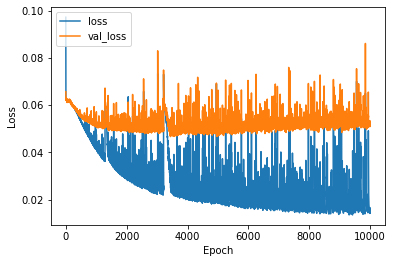

In [12]:
#Plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 1])
plt.legend(loc='upper left')